# Project for the course: Computational Mathematics
## Group 1: Fois Giulia, Manini Nicolas

 ### Parsing of the execution data of the algorithm and preliminary results on sparse matrices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read the summary csv, and the csv containing the execution logs for each task

In [2]:
Percentages = [10,30,60]
def getFolderName(perc):
    return 'Preliminary_Sparse_' + str(perc)

SummaryFile = 'summary.csv'
LogsFolder = 'logs'

In [3]:
dfSum = {}
for perc in Percentages:
    folderName = getFolderName(perc)
    summary_path = "{}/{}".format(folderName, SummaryFile)
    dfTmp = pd.read_csv(summary_path)
    dfTmp['density'] = perc
    
    dfTmp['Batch'] = dfTmp['InputName'].str.split('_').str[1]
    dfTmp['BatchIndex'] = dfTmp['InputName'].str.split('_').str[2]
    dfTmp['KIndex'] = dfTmp['InputName'].str.split('_').str[3]

    dfTmp['Batch'] = dfTmp['Batch'].astype(int)
    dfTmp['BatchIndex'] = dfTmp['BatchIndex'].astype(int)
    dfTmp['KIndex'] = dfTmp['KIndex'].astype(int)

    dfTmp['TimeIter'] = dfTmp['Our_time'].div(dfTmp['Our_Iter'])
    dfTmp['TimeDelta_1Iter'] = dfTmp['Svd_time'] - dfTmp['TimeIter']
    dfTmp['ConvenientIters'] = np.floor(dfTmp['Svd_time'] .div(dfTmp['TimeIter']))

    dfSum[perc] = dfTmp
    
dfSumAll = pd.concat([dfSum[x] for x in Percentages])

In [25]:
dfSumAll

,InputName,InputM,InputN,InputRk,TargetRk,Opt_delta,Our_delta,Delta_diff,Svd_time,Our_time,Time_gain,Our_Iter,density,Batch,BatchIndex,KIndex,TimeIter,TimeDelta_1Iter,ConvenientIters
0,srnd_1_1_1,10,10,6,2,0.586548,0.586551,2.651903e-06,0.000093,0.025204,-0.025110,75,10,1,1,1,0.000336,-0.000243,0.0
1,srnd_1_1_2,10,10,6,3,0.437065,0.437114,4.864264e-05,0.000093,0.034606,-0.034513,227,10,1,1,2,0.000152,-0.000059,0.0
2,srnd_1_1_3,10,10,6,4,0.198526,0.198526,9.799981e-09,0.000093,0.004471,-0.004378,8,10,1,1,3,0.000559,-0.000466,0.0
3,srnd_1_1_4,10,10,6,5,0.104373,0.198526,9.415302e-02,0.000093,0.006919,-0.006826,13,10,1,1,4,0.000532,-0.000439,0.0
4,srnd_1_2_1,10,10,6,2,0.588009,0.588010,5.622815e-07,0.000077,0.008643,-0.008566,23,10,1,2,1,0.000376,-0.000299,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,srnd_6_3_2,320,320,320,65,0.551263,0.551310,4.718373e-05,0.011896,4.074496,-4.062600,106,60,6,3,2,0.038439,-0.026543,0.0
104,srnd_6_3_3,320,320,320,129,0.348165,0.348200,3.462522e-05,0.011896,7.722123,-7.710227,106,60,6,3,3,0.072850,-0.060954,0.0
105,srnd_6_3_4,320,320,320,192,0.187747,0.187758,1.107922e-05,0.011896,23.314626,-23.302730,218,60,6,3,4,0.106948,-0.095052,0.0
106,srnd_6_3_5,320,320,320,256,0.066313,0.066314,8.382984e-07,0.011896,14.293398,-14.281502,98,60,6,3,5,0.145851,-0.133955,0.0


In [4]:
import os
dfLogs = {}
for perc in Percentages:
    folderName = getFolderName(perc)
    logs_path = "{}/{}".format(folderName, LogsFolder)
    for filename in filter(lambda x:x.endswith(".csv"), os.listdir(logs_path)):
        dfTemp = pd.read_csv("{}/{}".format(logs_path, filename))
        dfTemp['ErrorRatio'] = (abs(dfTemp['Error'] - dfTemp['Error'].shift(1))).div(dfTemp['Error'].shift(1))
        
        spl = filename.split('_')
        batch = int(spl[2])
        bidx = int(spl[3])
        kidx = int(spl[4][:-4])
        dfLogs[(perc, batch, bidx, kidx)] = dfTemp  

In [5]:
dfGroupLast = {}

# We consider only rk(A)-1 approximation
for perc in Percentages:
    dfTmp = dfSum[perc]
    dfFilt = dfTmp[dfTmp['InputRk'] == (dfTmp['TargetRk'] + 1)][['density', 'InputM', 'InputRk', 'TargetRk', 'Delta_diff']]
    dfGrouped = dfFilt.groupby('InputM').mean()
    dfGroupLast[perc] = dfGrouped

In [6]:
dfGroupLast[60]

,density,InputRk,TargetRk,Delta_diff
InputM,,,,
10,60,10,9,5.138120e-10
20,60,20,19,5.418578e-11
40,60,40,39,1.090192e-11
80,60,80,79,5.978571e-11
160,60,160,159,6.353945e-11
320,60,320,319,1.925387e-11


### Preliminary plots

In [8]:
def getColor(perc):
    if perc == 10:
        clr = 'red'
    if perc == 30:
        clr = 'blue'
    if perc == 60:
        clr = 'green'
    return clr

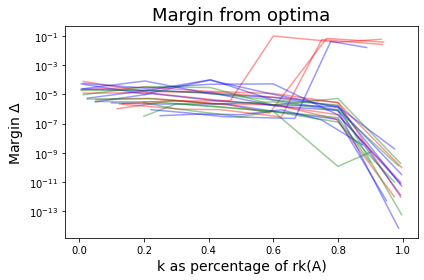

In [10]:
import random as rnd
rnd.seed(12)

plt.yscale('log')

for perc in Percentages:
    dfTmp = dfSum[perc]
    Batches = (dfTmp['Batch'].unique())
    for b in Batches:
        bidxs = dfTmp[dfTmp['Batch'] == b]['BatchIndex'].unique()
        kidxs = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidxs[0])]['KIndex'].unique()
        nks = len(kidxs)
        for bidx in bidxs:
            ks = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidx)]['TargetRk']

            origRank = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidx)]['InputRk'].iloc[0]
            xax = ks/origRank

            matrixM = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidx)]['InputM'].iloc[0]
            matrixN = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidx)]['InputN'].iloc[0]

            yax = dfTmp[(dfTmp['Batch'] == b) & (dfTmp['BatchIndex'] == bidx)]['Delta_diff']


            if (rnd.random() < 0.40): 
                plt.plot(xax, yax, color=getColor(perc), alpha=0.4)
            
            
plt.title("Margin from optima", fontsize=18)
plt.xlabel("k as percentage of rk(A)", fontsize=14)
plt.ylabel(r'Margin $\Delta$', fontsize=14)
plt.tight_layout()
plt.savefig('confronto_margin_sparse.png', format='png', dpi=300)
plt.show()

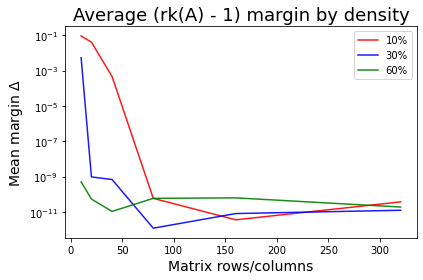

In [24]:
plt.yscale('log')
for perc in Percentages:
    dfTmp = dfGroupLast[perc]
    xax = list(dfTmp.index)
    yax = dfTmp['Delta_diff']
    plt.plot(xax, yax, color=getColor(perc), alpha=0.9, label="{}%".format(perc))

plt.legend(loc="best")

plt.title("Average (rk(A) - 1) margin by density", fontsize=18)
plt.xlabel("Matrix rows/columns", fontsize=14)
plt.ylabel(r'Mean margin $\Delta$', fontsize=14)
plt.tight_layout()
plt.savefig('confronto_margin_size_sparse.png', format='png', dpi=300)
plt.show()